In [3]:
import numpy as np
import jax.numpy as jnp
import jax


import functools
from dataclasses import dataclass
from typing import Tuple
from jax.scipy.special import logsumexp
import jax
import genjax
import matplotlib.pyplot as plt
# import open3d as o3d

In [4]:

# move point cloud to a specified pose
# coords: (N,3) point cloud
# pose: (4,4) pose matrix. rotation matrix in top left (3,3) and translation in (:3,3)
def apply_transform(coords, transform):
    coords = jnp.einsum(
        'ij,...j->...i',
        transform,
        jnp.concatenate([coords, jnp.ones(coords.shape[:-1] + (1,))], axis=-1),
    )[..., :-1]
    return coords

# render single object model cloud at specified pose to a "coordinate image"
# "coordinate image" is (h,w,3) where at each pixel we have the 3d coordinate of that point
# input_cloud: (N,3) object model point cloud
# pose: (4,4) pose matrix. rotation matrix in top left (3,3) and translation in (:3,3)
# h,w : height and width
# fx_fy : focal lengths
# cx_cy : principal point
# output: (h,w,3) coordinate image
@functools.partial(jax.jit, static_argnames=["h","w"])
def render_cloud_at_pose(input_cloud, pose, h, w, fx_fy, cx_cy):
    transformed_cloud = apply_transform(input_cloud, pose)
    point_cloud = jnp.vstack([
        -1.0 * jnp.ones((1,3)),
        transformed_cloud
    ])

    point_cloud_normalized =  point_cloud / point_cloud[:,2].reshape(-1,1)
    temp1 = point_cloud_normalized[:, :2] * fx_fy.transpose()
    temp2 = temp1 + cx_cy
    pixels = jnp.round(temp2)

    x,y = jnp.meshgrid(jnp.arange(h), jnp.arange(w))
    matches = (x[:,:,None] == pixels[:,0]) & (y[:,:,None] == pixels[:,1])
    a = jnp.argmax(matches,axis=-1)
    return point_cloud[a]

In [5]:
object_model_cloud = np.random.rand(200,3) * 2.0
object_model_cloud = jnp.array(object_model_cloud)

h,w,fx_fy,cx_cy = 120, 160, jnp.array([200.0, 200.0]), jnp.array([60.0, 80.0])
r = 0.1
outlier_prob =  0.01

gt_pose = jnp.array([
     [1.0, 0.0, 0.0, 2.0],   
     [0.0, 1.0, 0.0, 0.0],   
     [0.0, 0.0, 1.0, 10.0],   
     [0.0, 0.0, 0.0, 1.0],   
    ]
)
gt_image = render_cloud_at_pose(object_model_cloud, gt_pose,h,w,fx_fy,cx_cy)
print((gt_image[:,:,2] > 0).sum())

115


In [6]:
rendered_image = gt_image

In [7]:
rendered_image.shape, gt_image.shape

((160, 120, 3), (160, 120, 3))

In [8]:

@functools.partial(jax.jit, static_argnames="filter_shape")
def extract_2d_patches(data: jnp.ndarray, filter_shape: Tuple[int, int]) -> jnp.ndarray:
    """For each pixel, extract 2D patches centered at that pixel.
    Args:
        data (jnp.ndarray): Array of shape (H, W, ...)
            data needs to be 2, 3, or 4 dimensional.
        filter_shape (Tuple[int, int]): Size of the patches in H, W dimensions
    Returns:
        extracted_patches: Array of shape (H, W, filter_shape[0], filter_shape[1], C)
            extracted_patches[i, j] == data[
                i - filter_shape[0] // 2:i + filter_shape[0] - filter_shape[0] // 2,
                j - filter_shape[1] // 2:j + filter_shape[1] - filter_shape[1] // 2,
            ]
    """
    assert len(filter_shape) == 2
    output_shape = data.shape + filter_shape
    if data.ndim == 2:
        data = data[..., None, None]
    elif data.ndim == 3:
        data = data[:, :, None]

    padding = [
        (filter_shape[ii] // 2, filter_shape[ii] - filter_shape[ii] // 2 - 1)
        for ii in range(len(filter_shape))
    ]
    extracted_patches = jnp.moveaxis(
        jax.lax.conv_general_dilated_patches(
            lhs=data,
            filter_shape=filter_shape,
            window_strides=(1, 1),
            padding=padding,
            dimension_numbers=("HWNC", "OIHW", "HWNC"),
        ).reshape(output_shape),
        (-2, -1),
        (2, 3),
    )
    return extracted_patches

@functools.partial(jax.jit, static_argnames=["r", "outlier_prob"])
def neural_descriptor_likelihood(
    obs_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    r,
    outlier_prob
):
    obs_mask = obs_xyz[:,:,2] > 0
    rendered_mask = rendered_xyz[:,:,2] > 0
    num_latent_points = rendered_mask.sum()
    rendered_xyz_patches = extract_2d_patches(rendered_xyz, (4,4))
    log_mixture_prob = log_likelihood_for_pixel(
        obs_xyz,
        rendered_xyz_patches,
        r,
        outlier_prob,
        num_latent_points
    )
    return jnp.sum(jnp.where(obs_mask, log_mixture_prob, 0.0))


@functools.partial(
    jnp.vectorize,
    signature='(m),(h,w,m)->()',
    excluded=(2, 3, 4),
)
def log_likelihood_for_pixel(
    data_xyz: jnp.ndarray,
    model_xyz: jnp.ndarray,
    r: float,
    outlier_prob: float,
    num_latent_points: float,
):
    """    Args:
        data_xyz (jnp.ndarray): (3,)
            3d coordinate of observed point
        model_xyz : (filter_height, filter_width, 3),
        r : float, sphere radius
        outlier_prob: float
        num_latent_points: int
    """
    distance = jnp.linalg.norm(data_xyz - model_xyz, axis=-1).ravel() # (4,4)
    
    return jnp.log(jnp.sum(outlier_prob + jnp.where(
        distance <= r,
        1 / (4 * ((1 - outlier_prob)/num_latent_points) * jnp.pi * r**3) / (3 ),
        0.0,
    )))
    return a


@dataclass
class _NeuralDescriptorLikelihood(genjax.Distribution):
    def sample(self, key, *args, **kwargs):
        return key, ()

    def logpdf(self, key, image, *args):
        return neural_descriptor_likelihood(image, *args)


NeuralDescriptorLikelihood = _NeuralDescriptorLikelihood()


In [9]:
object_model_cloud = np.random.rand(200,3) * 2.0
object_model_cloud = jnp.array(object_model_cloud)

h,w,fx_fy,cx_cy = 120, 160, jnp.array([200.0, 200.0]), jnp.array([60.0, 80.0])
r = 0.3
outlier_prob =  0.01

gt_pose = jnp.array([
     [1.0, 0.0, 0.0, 0.0],   
     [0.0, 1.0, 0.0, 0.0],   
     [0.0, 0.0, 1.0, 20.0],   
     [0.0, 0.0, 0.0, 1.0],   
    ]
)
gt_image = render_cloud_at_pose(object_model_cloud, gt_pose,h,w,fx_fy,cx_cy)
print((gt_image[:,:,2] > 0).sum())

155


In [10]:

@genjax.gen
def model(key, object_model_cloud):
    key, x = genjax.trace("x", genjax.Uniform)(key, (-10.0, 10.0))
    pose = jnp.array(
        [
            [1.0, 0.0, 0.0, x],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 20.0],
            [0.0, 0.0, 0.0, 1.0],
        ]
    )
    rendered_image = render_cloud_at_pose(
        object_model_cloud, pose, h, w, fx_fy, cx_cy
    )
    key, cloud = genjax.trace("observed", NeuralDescriptorLikelihood)(
        key, (rendered_image, r, outlier_prob)
    )
    return key, rendered_image.shape

In [11]:

@functools.partial(
    jnp.vectorize,
)
def evaluate_likelihood(
    x: float
):
    latent_pose = jnp.array(
        [
            [1.0, 0.0, 0.0, x],   
            [0.0, 1.0, 0.0, 0.0],   
            [0.0, 0.0, 1.0, 20.0],   
            [0.0, 0.0, 0.0, 1.0],   
        ]
    )
    rendered_image = render_cloud_at_pose(object_model_cloud, latent_pose, h,w,fx_fy,cx_cy)

    ### Make distribution whos logscore is
    score = neural_descriptor_likelihood(gt_image, rendered_image, r, outlier_prob)
    return score

In [12]:
def scorer(key, x):
    obs = genjax.ChoiceMap.new({("x",): x, ("observed",): gt_image})
    key, (weight, tr) = model.importance(key, obs, (object_model_cloud, ))
    return key, weight, x, tr

In [14]:
key = jax.random.PRNGKey(3)

In [15]:
%%time
xs = jnp.linspace(-2.0, 4.0, 1000)
key, *sub_keys = jax.random.split(key, len(xs) + 1)
sub_keys = jnp.array(sub_keys)
f = jax.jit(jax.vmap(scorer, in_axes = (0, 0)))

evaluate_likelihood_jit = jax.jit(evaluate_likelihood)


CPU times: user 1.12 s, sys: 78.3 ms, total: 1.19 s
Wall time: 1.95 s


In [26]:
%%time 
_, weights_new, passed_through, traces = f(sub_keys, xs)

CPU times: user 62.1 ms, sys: 28 ms, total: 90 ms
Wall time: 88.4 ms


In [33]:
traces["observed"].shape

(1000, 160, 120, 3)

In [27]:
%%time
weights_old = evaluate_likelihood_jit(xs)


CPU times: user 54.8 ms, sys: 29.2 ms, total: 84 ms
Wall time: 82.5 ms


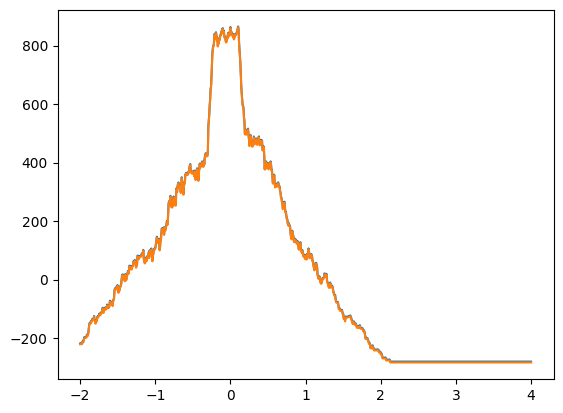

In [22]:
plt.plot(np.array(xs), weights_old)
plt.plot(np.array(xs), weights_new)

In [351]:
weights_new

DeviceArray([-301.01337, -301.01337, -301.01337, ...,  161.16418,
              161.85686,  161.85686], dtype=float32)

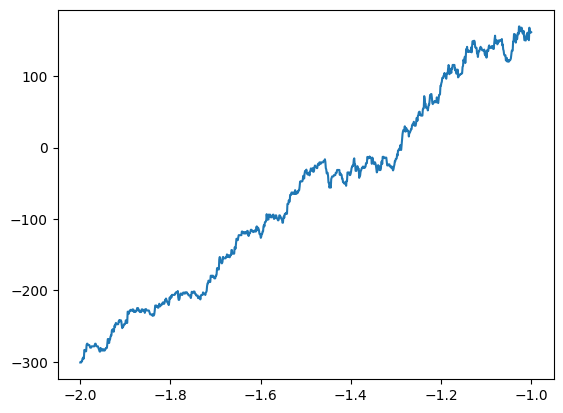

In [252]:
np.zip(np.array(

SyntaxError: incomplete input (352423322.py, line 1)

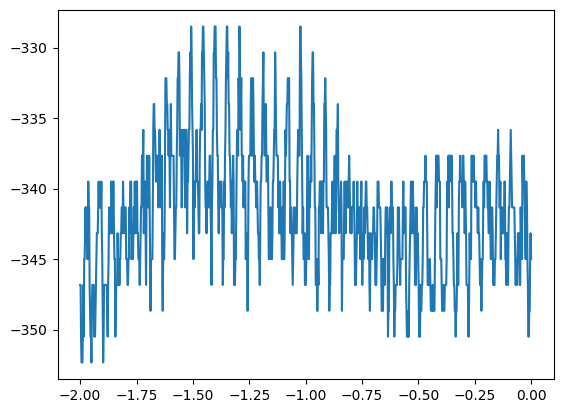

In [ ]:
plt.clf()
plt.plot(np.array(xs), weights)

In [158]:
weights

DeviceArray([-295.51566, -295.51566, -293.68304, -295.51566, -293.68304,
             -295.51566, -291.8505 , -288.1853 , -288.1853 , -288.18533,
             -291.8505 , -286.35275, -280.85495, -282.68756, -282.6876 ,
             -282.68756, -284.52014, -282.68756, -280.85495, -280.85495,
             -282.68753, -282.68753, -286.35272, -286.35272, -286.3527 ,
             -290.01785, -291.85043, -290.01785, -293.68304, -295.5156 ,
             -297.34824, -297.34824, -297.34824, -299.1808 , -297.3482 ,
             -293.683  , -297.34818, -297.34818, -297.34818, -297.34818,
             -295.5156 , -288.18527, -291.85043, -291.85043, -293.683  ,
             -293.683  , -295.5156 , -299.18076, -301.0134 , -297.34824,
             -299.18082, -299.18082, -299.18082, -297.3482 , -297.3482 ,
             -295.51566, -297.34824, -295.51566, -295.51566, -293.68307,
             -291.8505 , -293.68307, -284.52017, -284.52014, -284.52014,
             -282.68753, -277.1898 , -279.0224 , -2

In [141]:
np.array(weights).shape

(1000,)

In [316]:
genjax.Uniform.logpdf((), 0.5, minval=-10.0, maxval=10.0)

DeviceArray(-inf, dtype=float32)